In [1]:
!pip install daal==2021.4.0 requests_mock numpy==1.22 clyent==1.2.1 nbformat==5.4.0

In [2]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

## Import libraries

In [87]:
import numpy as np
import scipy as cp
import tensorflow as tf
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import sys
import gtts
import os
from playsound import playsound
language = 'id'

## Webcam

In [2]:
# media pipeline for drawing key points
mp_model = mp.solutions.holistic     # holistic model
mp_draw = mp.solutions.drawing_utils # drawing utilities

In [3]:
def mediapipe_detection(image, model):
    # convert the image from bgr to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # make image not writable
    image.flags.writeable = False
    # predict the image
    res = model.process(image)
    # image become writeable again
    image.flags.writeable = True
    # change back from rgb to bgr
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, res

In [4]:
# same as draw function but its color is different (just for appearance)
def draw_with_style(image, res):
    mp_draw.draw_landmarks(image, res.face_landmarks, mp_model.FACEMESH_TESSELATION,
                          mp_draw.DrawingSpec(color=(231, 111, 81), thickness=1, circle_radius=1),
                          mp_draw.DrawingSpec(color=(233, 196, 106), thickness=1, circle_radius=1))
    mp_draw.draw_landmarks(image, res.left_hand_landmarks, mp_model.HAND_CONNECTIONS,
                          mp_draw.DrawingSpec(color=(38, 70, 83), thickness=1, circle_radius=2),
                          mp_draw.DrawingSpec(color=(215, 180, 255), thickness=1, circle_radius=1))
    mp_draw.draw_landmarks(image, res.right_hand_landmarks, mp_model.HAND_CONNECTIONS,
                          mp_draw.DrawingSpec(color=(38, 70, 83), thickness=1, circle_radius=2),
                          mp_draw.DrawingSpec(color=(215, 180, 255), thickness=1, circle_radius=1))
    mp_draw.draw_landmarks(image, res.pose_landmarks, mp_model.POSE_CONNECTIONS,
                          mp_draw.DrawingSpec(color=(24, 38, 77), thickness=1, circle_radius=2),
                          mp_draw.DrawingSpec(color=(128, 228, 216), thickness=1, circle_radius=1))

In [5]:
def draw(image, res):
    # connection contains information that some part of body is connected to other part of body
    mp_draw.draw_landmarks(image, res.face_landmarks, mp_model.FACEMESH_TESSELATION)
    mp_draw.draw_landmarks(image, res.left_hand_landmarks, mp_model.HAND_CONNECTIONS)
    mp_draw.draw_landmarks(image, res.right_hand_landmarks, mp_model.HAND_CONNECTIONS)
    mp_draw.draw_landmarks(image, res.pose_landmarks, mp_model.POSE_CONNECTIONS)

In [15]:
# testing camera with media pipe
cap = cv2.VideoCapture(0)
with mp_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as model:
    while cap.isOpened():
        ret, frame = cap.read()
        # make detection
        image, res = mediapipe_detection(frame, model)
        # draw landmarks to image based on the result
        draw_with_style(image, res)
        # show to our screen (frame name, frame)
        cv2.imshow('OpenCV frame', image)
        # Break using 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    # release our webcam
    cap.release()
    # close the frame
    cv2.destroyAllWindows()

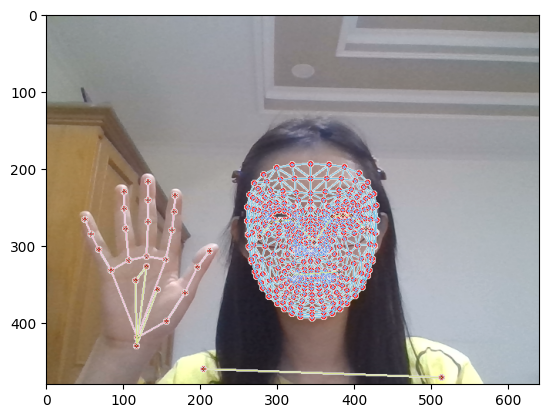

In [18]:
# testing camera result
draw_with_style(frame, res)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## Extracting points

In [6]:
def get_points(res):
    pose = []
    if res.pose_landmarks:
        for point in res.pose_landmarks.landmark:
            test = np.array([point.x, point.y, point.z, point.visibility])
            pose.append(test)
        # change to np array and concatenate all array points inside pose
        pose = np.array(pose)
        pose = pose.flatten()
    else:
        # there are 33 landmarks, multiplied by 4 each
        pose = np.zeros(33*4)
        
    face = []
    if res.face_landmarks:
        for point in res.face_landmarks.landmark:
            test = np.array([point.x, point.y, point.z])
            face.append(test)
        # change to np array and concatenate all array points inside pose
        face = np.array(face)
        face = face.flatten()
    else:
        face = np.zeros(468*3)

    left_hand = []
    if res.left_hand_landmarks:
        for point in res.left_hand_landmarks.landmark:
            test = np.array([point.x, point.y, point.z])
            left_hand.append(test)
        # change to np array and concatenate all array points inside pose
        left_hand = np.array(left_hand)
        left_hand = left_hand.flatten()
    else:
        left_hand = np.zeros(21*3)

    right_hand = []
    if res.right_hand_landmarks:
        for point in res.right_hand_landmarks.landmark:
            test = np.array([point.x, point.y, point.z])
            right_hand.append(test)
        # change to np array and concatenate all array points inside pose
        right_hand = np.array(right_hand)
        right_hand = right_hand.flatten()
    else:
        right_hand = np.zeros(21*3)
    
#     print(pose.shape)
#     print(face.shape)
#     print(left_hand.shape)
#     print(right_hand.shape)
        
    # concatenate all arrays
    return np.concatenate([pose, face, left_hand, right_hand])

## Make folders

In [7]:
# path for get points data
data_path = os.path.join('mp_data')
# sign that we try to detect
signs = np.array(['halo', 'aku', 'hobi', 'baca', 'terimakasih'])
# capture 30 videos for data
videos = 30
# how many frames we want per video
frame_per_video = 30

## Collecting data

In [8]:
for sign in signs:
    for video in range(videos):
        try:
            os.makedirs(os.path.join(data_path, sign, str(video)))
        except:
            pass

## Collect keypoint for training and testing

In [9]:
cap = cv2.VideoCapture(0)
with mp_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as model:
    for sign in signs:
        for video in range(videos):
            for frame_num in range(frame_per_video):
                # read
                ret, frame = cap.read()
                # make detection
                image, res = mediapipe_detection(frame, model)
                # draw landmarks to image based on the result
                draw_with_style(image, res)
                
                # print text to tell us which part of data we are collecting now
                if frame_num == 0:
                    cv2.putText(image, 'Starting to collect', (120, 200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 2555, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} video number {}'.format(sign, video), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # show
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(3000)
                else:
                    cv2.putText(image, 'Collecting frames for {} video number {}'.format(sign, video), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # show
                    cv2.imshow('OpenCV Feed', image)
                    
                # export keypoints
                keypoints = get_points(res)
                path_now = os.path.join(data_path, sign, str(video), str(frame_num))
                np.save(path_now, keypoints)
                
                # Break using 'q'
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    # release our webcam
    cap.release()
    # close the frame
    cv2.destroyAllWindows()

## Preprocess data and create labels + features

In [8]:
# create map
label_map = {label:num for num, label in enumerate(signs)}

In [9]:
label_map

{'halo': 0, 'aku': 1, 'hobi': 2, 'baca': 3, 'terimakasih': 4}

In [10]:
sequences = [] # x data
labels = []    # y data
for sign in signs:
    for video in range(videos):
        window = []
        for frame_num in range(frame_per_video):
            res = np.load(os.path.join(data_path, sign, str(video), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[sign])

In [11]:
print(np.array(sequences).shape)
print(np.array(labels).shape)

(150, 30, 1662)
(150,)


In [11]:
# Each binary form represents 'halo', 'aku', etc.
X = np.array(sequences)
y = to_categorical(labels).astype(int)
# print(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08)

In [18]:
print(X_train.shape)
print(y_test.shape)

(138, 30, 1662)
(12, 5)


## Build LSTM model

In [47]:
# Using TensorBoard because it is really helpful to
# let us track the accuracy of the model while it is still in training
log_dir = os.path.join('Log_fin')
tb_callback = TensorBoard(log_dir = log_dir)

In [72]:
# Get sequential API to help us to build model by adding up layers easily
model_train = Sequential()
model_train.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30,1662)))
model_train.add(LSTM(256, return_sequences=True, activation='relu'))
# The layer below has return_sequences false because after that layer we are going to have dense layer
model_train.add(LSTM(128, return_sequences=False, activation='relu'))
model_train.add(Dense(128, activation='relu'))
model_train.add(Dense(64, activation='relu'))
model_train.add(Dense(signs.shape[0], activation='softmax'))

In [73]:
# Using cateogrical_crossentropy not MSE because the model is multiclass classification model
model_train.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

## Train model

In [74]:
model_train.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
5/5 [==============================] - 5s 290ms/step - loss: 1.7514 - categorical_accuracy: 0.2101
Epoch 2/2000
5/5 [==============================] - 1s 289ms/step - loss: 1.9374 - categorical_accuracy: 0.1667
Epoch 3/2000
5/5 [==============================] - 1s 288ms/step - loss: 1.5833 - categorical_accuracy: 0.1594
Epoch 4/2000
5/5 [==============================] - 1s 286ms/step - loss: 1.5414 - categorical_accuracy: 0.3913
Epoch 5/2000
5/5 [==============================] - 1s 283ms/step - loss: 2.1894 - categorical_accuracy: 0.2101
Epoch 6/2000
5/5 [==============================] - 1s 298ms/step - loss: 1.5949 - categorical_accuracy: 0.1957
Epoch 7/2000
5/5 [==============================] - 2s 302ms/step - loss: 1.5964 - categorical_accuracy: 0.2246
Epoch 8/2000
5/5 [==============================] - 1s 289ms/step - loss: 1.4376 - categorical_accuracy: 0.4130
Epoch 9/2000
5/5 [==============================] - 2s 300ms/step - loss: 1.2762 - categorical_accuracy:

5/5 [==============================] - 1s 294ms/step - loss: 0.0637 - categorical_accuracy: 0.9855
Epoch 74/2000
5/5 [==============================] - 1s 291ms/step - loss: 0.0314 - categorical_accuracy: 0.9928
Epoch 75/2000
5/5 [==============================] - 1s 289ms/step - loss: 0.0701 - categorical_accuracy: 0.9710
Epoch 76/2000
5/5 [==============================] - 1s 288ms/step - loss: 1.0540 - categorical_accuracy: 0.7246
Epoch 77/2000
5/5 [==============================] - 1s 292ms/step - loss: 0.5237 - categorical_accuracy: 0.8188
Epoch 78/2000
5/5 [==============================] - 1s 291ms/step - loss: 0.3930 - categorical_accuracy: 0.8623
Epoch 79/2000
5/5 [==============================] - 1s 293ms/step - loss: 0.3328 - categorical_accuracy: 0.9203
Epoch 80/2000
5/5 [==============================] - 2s 311ms/step - loss: 0.2917 - categorical_accuracy: 0.8986
Epoch 81/2000
5/5 [==============================] - 1s 294ms/step - loss: 0.2890 - categorical_accuracy: 0.92

KeyboardInterrupt: 

In [75]:
model_train.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 30, 128)           916992    
                                                                 
 lstm_67 (LSTM)              (None, 30, 256)           394240    
                                                                 
 lstm_68 (LSTM)              (None, 128)               197120    
                                                                 
 dense_42 (Dense)            (None, 128)               16512     
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dense_44 (Dense)            (None, 5)                 325       
                                                                 
Total params: 1533445 (5.85 MB)
Trainable params: 153

## Make predictions

In [76]:
res = model_train.predict(X_test)
print(res.shape)

1/1 [==============================] - 0s 382ms/step
(12, 5)


In [77]:
signs[np.argmax(res[0])]

'hobi'

In [78]:
signs[np.argmax(y_test[0])]

'hobi'

## Save weights

In [79]:
model_train.save('action_final.hS')

INFO:tensorflow:Assets written to: action_final.hS\assets


INFO:tensorflow:Assets written to: action_final.hS\assets


In [81]:
model_train.load_weights('action_final.hS')

## Evaluation using confusion matrix and accuracy

In [82]:
y_hat = model_train.predict(X_test)

1/1 [==============================] - 0s 61ms/step


In [83]:
y_true = np.argmax(y_test, axis=1).tolist()
y_hat = np.argmax(y_hat, axis=1).tolist()

In [84]:
y_true

[2, 3, 4, 3, 2, 4, 1, 2, 1, 1, 0, 2]

In [85]:
multilabel_confusion_matrix(y_true, y_hat)

array([[[11,  0],
        [ 0,  1]],

       [[ 9,  0],
        [ 0,  3]],

       [[ 8,  0],
        [ 0,  4]],

       [[10,  0],
        [ 0,  2]],

       [[10,  0],
        [ 0,  2]]], dtype=int64)

In [86]:
accuracy_score(y_true, y_hat)

1.0

## Test in real time

In [88]:
colors = [(245, 117, 16), (117, 245, 16), (916, 117, 245), (245, 117, 16), (117, 245, 16)]

def prob_viz(res, signs, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, signs[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [89]:
# change word to speech
def speak(word_to_speak):
    word = gtts.gTTS(text=word_to_speak, lang=language)
    word.save("kalimat.mp3")
    playsound("kalimat.mp3")
    if os.path.exists("kalimat.mp3"):
        os.remove("kalimat.mp3")
    else:
        print("Audio file does not exists")

In [90]:
# sequence for collect 30 frames
sequence = []
# keep all the words
sentence = []
predictions = []
thres = 0.8
cap = cv2.VideoCapture(0)
with mp_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as model:
    while cap.isOpened():
        ret, frame = cap.read()
        # make detection
        image, results = mediapipe_detection(frame, model)
        # draw landmarks to image based on the result
        draw_with_style(image, results)
        # predict
        keypoints = get_points(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        if len(sequence) == 30:
            res = model_train.predict(np.expand_dims(sequence, axis=0))[0]
            print(signs[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                # show to our screen (frame name, frame)
                if res[np.argmax(res)] > thres:
                    if len(sentence) > 0:
                        # if the sentence is not empty 
                        # AND
                        # if our current predicted word is not the same as
                        # the word that are predicted right before now
                        # then append current word
                        if signs[np.argmax(res)] != sentence[-1]:
                            sentence.append(signs[np.argmax(res)])
                            speak(signs[np.argmax(res)])
                    else:
                        # if sentence is empty, append word
                        sentence.append(signs[np.argmax(res)])
                        speak(signs[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]
            
            # visualization with probability of each word
            image = prob_viz(res, signs, image, colors)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                   (255, 255, 255), 2, cv2.LINE_AA)

        # show to screen
        cv2.imshow('OpenCV frame', image)
        # Break using 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    # release our webcam
    cap.release()
    # close the frame
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 34ms/step
halo
1/1 [==============================] - 0s 35ms/step
halo
1/1 [==============================] - 0s 39ms/step
halo
1/1 [==============================] - 0s 31ms/step
halo
1/1 [==============================] - 0s 36ms/step
halo
1/1 [==============================] - 0s 32ms/step
halo
1/1 [==============================] - 0s 27ms/step
halo
1/1 [==============================] - 0s 29ms/step
halo
1/1 [==============================] - 0s 42ms/step
halo
1/1 [==============================] - 0s 28ms/step
halo
1/1 [==============================] - 0s 43ms/step
halo
1/1 [==============================] - 0s 26ms/step
halo
1/1 [==============================] - 0s 23ms/step
halo
1/1 [==============================] - 0s 39ms/step
halo
1/1 [==============================] - 0s 30ms/step
halo
1/1 [==============================] - 0s 28ms/step
halo
1/1 [==============================] - 0s 32ms/step
halo
1/1 [==========================

1/1 [==============================] - 0s 35ms/step
terimakasih
1/1 [==============================] - 0s 33ms/step
terimakasih
1/1 [==============================] - 0s 37ms/step
terimakasih
1/1 [==============================] - 0s 26ms/step
baca
1/1 [==============================] - 0s 28ms/step
baca
1/1 [==============================] - 0s 37ms/step
baca
1/1 [==============================] - 0s 26ms/step
baca
1/1 [==============================] - 0s 33ms/step
baca
1/1 [==============================] - 0s 44ms/step
baca
1/1 [==============================] - 0s 37ms/step
baca
1/1 [==============================] - 0s 33ms/step
baca
1/1 [==============================] - 0s 38ms/step
baca
1/1 [==============================] - 0s 29ms/step
baca
1/1 [==============================] - 0s 28ms/step
hobi
1/1 [==============================] - 0s 28ms/step
hobi
1/1 [==============================] - 0s 27ms/step
hobi
1/1 [==============================] - 0s 28ms/step
hobi
1/1 [=====

1/1 [==============================] - 0s 30ms/step
hobi
1/1 [==============================] - 0s 34ms/step
hobi
1/1 [==============================] - 0s 36ms/step
hobi
1/1 [==============================] - 0s 25ms/step
hobi
1/1 [==============================] - 0s 35ms/step
hobi
1/1 [==============================] - 0s 35ms/step
hobi
1/1 [==============================] - 0s 26ms/step
hobi
1/1 [==============================] - 0s 29ms/step
hobi
1/1 [==============================] - 0s 28ms/step
hobi
1/1 [==============================] - 0s 36ms/step
hobi
1/1 [==============================] - 0s 38ms/step
hobi
1/1 [==============================] - 0s 27ms/step
hobi
1/1 [==============================] - 0s 25ms/step
baca
1/1 [==============================] - 0s 36ms/step
baca
1/1 [==============================] - 0s 31ms/step
baca
1/1 [==============================] - 0s 39ms/step
baca
1/1 [==============================] - 0s 32ms/step
baca
1/1 [==========================